# Kmeansによる自動分類

In [1]:
from sagemaker import get_execution_role

role = get_execution_role()
bucket='dge-sagemaker-test'

In [2]:
%%time
import pickle, gzip, numpy, urllib.request, json

# Load the dataset
urllib.request.urlretrieve("http://deeplearning.net/data/mnist/mnist.pkl.gz", "mnist.pkl.gz")
with gzip.open('mnist.pkl.gz', 'rb') as f:
    train_set, valid_set, test_set = pickle.load(f, encoding='latin1')

CPU times: user 895 ms, sys: 270 ms, total: 1.16 s
Wall time: 8.51 s


In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (2,10)

In [4]:
def show_digit(img, caption='', subplot=None):
    if subplot==None:
        _,(subplot)=plt.subplots(1,1)
    imgr=img.reshape((28,28))
    subplot.axis('off')
    subplot.imshow(imgr, cmap='gray')
    plt.title(caption)

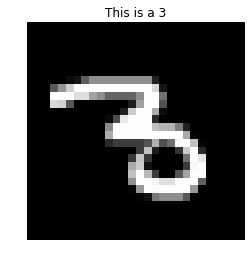

In [5]:
show_digit(train_set[0][30], 'This is a {}'.format(train_set[1][30]))

In [6]:
from sagemaker import KMeans

In [7]:
data_location = 's3://{}/kmeans_highlevel_example/data'.format(bucket)
output_location = 's3://{}/kmeans_example/output'.format(bucket)

print('training data will be uploaded to: {}'.format(data_location))
print('training artifacts will be uploaded to: {}'.format(output_location))

training data will be uploaded to: s3://dge-sagemaker-test/kmeans_highlevel_example/data
training artifacts will be uploaded to: s3://dge-sagemaker-test/kmeans_example/output


In [8]:
kmeans = KMeans(role=role,
                train_instance_count=2,
                train_instance_type='ml.c4.8xlarge',
                output_path=output_location,
                k=10,
                data_location=data_location)

In [9]:
%%time

kmeans.fit(kmeans.record_set(train_set[0]))

2020-07-08 07:14:58 Starting - Starting the training job...
2020-07-08 07:15:00 Starting - Launching requested ML instances.........
2020-07-08 07:16:40 Starting - Preparing the instances for training.........
2020-07-08 07:18:25 Downloading - Downloading input data
2020-07-08 07:18:25 Training - Training image download completed. Training in progress..Docker entrypoint called with argument(s): train
Running default environment configuration script
Docker entrypoint called with argument(s): train
Running default environment configuration script
[07/08/2020 07:18:28 INFO 140076629829440] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'_enable_profiler': u'false', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'local_lloyd_num_trials': u'auto', u'_log_level': u'info', u'_kvstore': u'auto', u'local_lloyd_init_method': u'kmeans++', u'force_dense': u'true', u'epochs': u'1', u'init_method': u'random', u'local_ll

In [10]:
%%time

kmeans_predictor = kmeans.deploy(initial_instance_count=1,
                                 instance_type='ml.m4.xlarge')

---------------!CPU times: user 256 ms, sys: 18.9 ms, total: 274 ms
Wall time: 7min 32s


In [11]:
result = kmeans_predictor.predict(valid_set[0][30:31])
print(result)

[label {
  key: "closest_cluster"
  value {
    float32_tensor {
      values: 8.0
    }
  }
}
label {
  key: "distance_to_cluster"
  value {
    float32_tensor {
      values: 5.591634273529053
    }
  }
}
]


In [12]:
%%time 

result = kmeans_predictor.predict(valid_set[0][0:100])
clusters = [r.label['closest_cluster'].float32_tensor.values[0] for r in result]

CPU times: user 25.7 ms, sys: 25 µs, total: 25.7 ms
Wall time: 88.2 ms





Cluster 0:


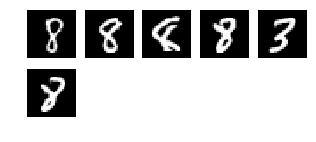




Cluster 1:


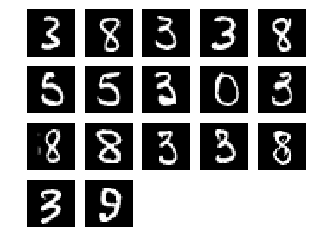




Cluster 2:


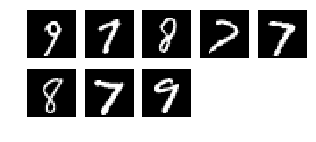




Cluster 3:


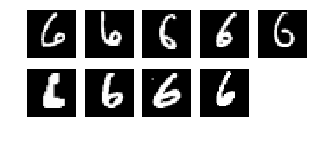




Cluster 4:


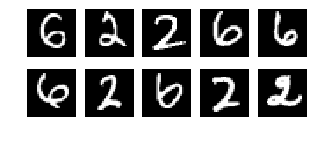




Cluster 5:


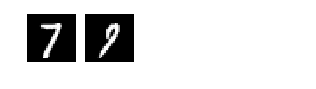




Cluster 6:


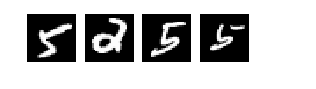




Cluster 7:


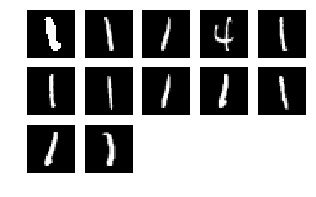




Cluster 8:


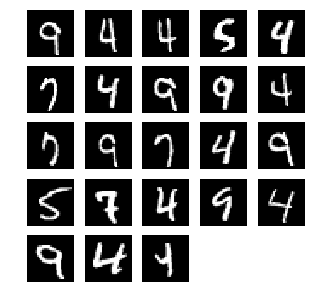




Cluster 9:


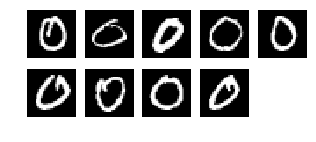

In [13]:
for cluster in range(10):
    print('\n\n\nCluster {}:'.format(int(cluster)))
    digits = [ img for l, img in zip(clusters, valid_set[0]) if int(l) == cluster ]
    height = ((len(digits)-1)//5) + 1
    width = 5
    plt.rcParams["figure.figsize"] = (width,height)
    _, subplots = plt.subplots(height, width)
    subplots = numpy.ndarray.flatten(subplots)
    for subplot, image in zip(subplots, digits):
        show_digit(image, subplot=subplot)
    for subplot in subplots[len(digits):]:
        subplot.axis('off')

    plt.show()

In [15]:
# Delete Endpoint
import sagemaker
sagemaker.Session().delete_endpoint(kmeans_predictor.endpoint)